# Для твоих вопросов или комментариев оставлю такую ячейку, чтобы было удобнее взаимодействовать на проекте

# Проект: Статистический анализ данных


Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки абонентская плата отсутствует;
Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.
Пользователи — users_go.csv
user_id	уникальный идентификатор пользователя
name	имя пользователя
age	возраст
city	город
subscription_type	тип подписки (free, ultra)
Поездки — rides_go.csv
user_id	уникальный идентификатор пользователя
distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
date	дата совершения поездки
Подписки — subscriptions_go.csv
subscription_type	тип подписки
minute_price	стоимость одной минуты поездки по данной подписке
start_ride_price	стоимость начала поездки
subscription_fee	стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import scipy.stats as st


#### Шаг 1. Загрузка данных

##### Шаг 1.1 Считываем CSV-файлы

In [2]:
users_df = pd.read_csv('/datasets/users_go.csv')
rides_df = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])
subscriptions_df = pd.read_csv('/datasets/subscriptions_go.csv')

##### Шаг 1.2 Выведите первые строки каждого набора данных.
#Изучите общую информацию о каждом датафрейме.

In [3]:
def display_dataset_info(dataset):
    display(dataset.head())
    dataset.info()
display_dataset_info(users_df)
display_dataset_info(rides_df)
display_dataset_info(subscriptions_df)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Вывод по разделу:данные позволяют анализировать активность пользователей, 
их поездки и использование различных типов подписок в сервисе.

#### Шаг 2. Предобработка данных

##### Шаг 2.1 Приведите столбец date к типу даты pandas.

In [4]:
rides_df['date'] = pd.to_datetime(rides_df['date'])

##### Шаг 2.2 Создайте новый столбец с номером месяца на основе столбца date.

In [5]:
min_date = rides_df['date'].min()
max_date = rides_df['date'].max()
display(f"Минимальная дата: {min_date}")
display(f"Максимальная дата: {max_date}")
rides_df['month'] = rides_df['date'].dt.month
rides_df['month'].value_counts()

'Минимальная дата: 2021-01-01 00:00:00'

'Максимальная дата: 2021-12-30 00:00:00'

1     1585
5     1560
6     1553
3     1544
7     1529
12    1527
8     1518
9     1517
4     1506
10    1475
11    1418
2     1336
Name: month, dtype: int64

Данные собраны за год, с 1 января 2021 года по 30 декабря 2021 года.

##### Шаг 2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах.
#Обработайте их, если такие значения присутствуют.

In [6]:
print("Пропущенные значения в Users DataFrame:")
print(users_df.isnull().sum())



display("\nПропущенные значения в Rides DataFrame:")
display(rides_df.isnull().sum())

display("\nПропущенные значения в Subscriptions DataFrame:")
display(subscriptions_df.isnull().sum())

display("\nДубликаты в Users DataFrame:")
display(users_df.duplicated().sum())
users_df.drop_duplicates(inplace=True)
#print(users_df.duplicated().sum())

 
display("\nДубликаты в Rides DataFrame:")
display(rides_df.duplicated().sum())

display("\nДубликаты в Subscriptions DataFrame:")
display(subscriptions_df.duplicated().sum())

Пропущенные значения в Users DataFrame:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


'\nПропущенные значения в Rides DataFrame:'

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

'\nПропущенные значения в Subscriptions DataFrame:'

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

'\nДубликаты в Users DataFrame:'

31

'\nДубликаты в Rides DataFrame:'

0

'\nДубликаты в Subscriptions DataFrame:'

0

Вывод по разделу: Были обнаружены дубликаты в таблице users_df, что может быть проблемой. 
Так как наличие дубликатов может привести к некорректным аналитическим результатам или ошибкам при анализе данных. Мы удалили дубликаты.
В остальных таблицах, замечаний нет.

#### Шаг 3. Исследовательский анализ данных

##### Шаг 3.1 Посмотрим на частоту встречаемости городов

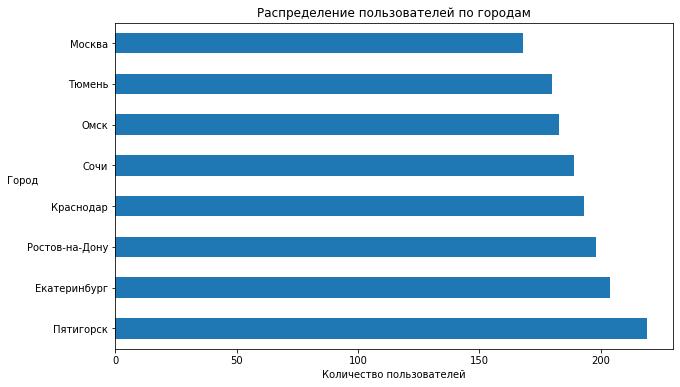

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [7]:
city_counts = users_df['city'].value_counts()
city_counts.plot(kind='barh', figsize=(10, 6), title='Распределение пользователей по городам')
plt.xlabel('Количество пользователей')
plt.ylabel('Город', rotation=0)
plt.show()
display(city_counts)

Вывод: Пользователи сервиса чаще всего выбирают города Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар и Сочи, однако общая разница в популярности всех городов невелика.

Вывод 2: Пятигорск имеет наибольшее количество пользователей, что на 30% больше чем в  Москве - в городе с наименьшим числом пользователей , что может быть интересным для бизнеса. В других городах, таких как Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень, также наблюдается разница в числе пользователей, что может быть обусловлено различными факторами. 

##### Шаг 3.2 Посмотрим на соотношение пользователей с подпиской и без подписки

free     835
ultra    699
Name: subscription_type, dtype: int64

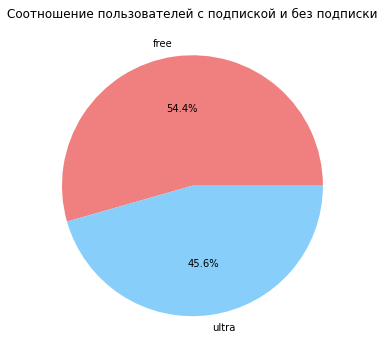

In [8]:
subscription_counts = users_df['subscription_type'].value_counts()
display(subscription_counts)
plt.figure(figsize=(6, 6))
subscription_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.show()


Вывод: Из 1534 пользователей, 54% имеют бесплатную подписку (835 человек), 
а 46% - платную подписку Ultra (699 человек).

##### Шаг 3.3 Посмотрим на возраст пользователей

In [9]:
age_counts = users_df['age'].value_counts()
display(users_df['age'].describe())
display(age_counts)


count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

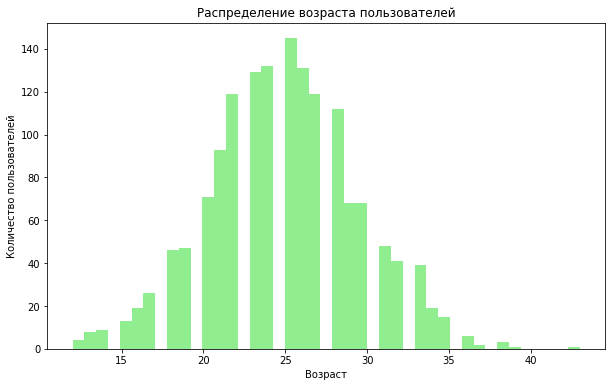

In [10]:
plt.figure(figsize=(10, 6))
users_df['age'].plot.hist(bins=43, color='lightgreen')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

По возрасту пользователей наиболее распространены возрастные категории от 20 до 30 лет, с пиком в 25 лет. 
В целом, пользователи в возрасте от 15 до 35 лет составляют основную часть аудитории сервиса.
Пользователей старше 35 лет значительно меньше.

##### Шаг 3.4 Посмотрим на расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

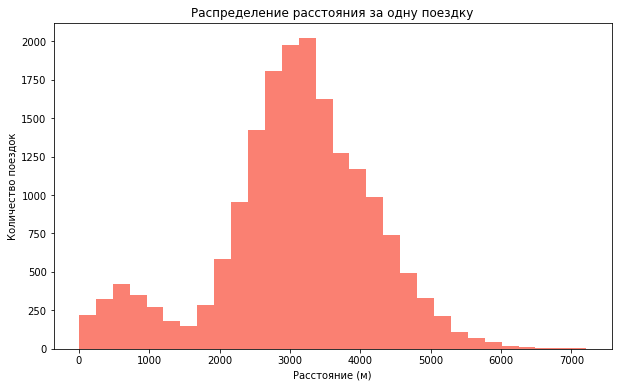

In [11]:
distance_counts = rides_df['distance'].describe()
display(distance_counts)
plt.figure(figsize=(10, 6))
rides_df['distance'].plot.hist(bins=30, color='salmon')
plt.title('Распределение расстояния за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.show()

In [12]:
travel_df = pd.merge(users_df, rides_df, on='user_id', how='inner')
short_rides = travel_df[travel_df['distance'] <= 1000]

age_short_rides = short_rides.groupby('age').size().sort_values(ascending=False).head(1)
subscription_short_rides = short_rides.groupby('subscription_type').size().sort_values(ascending=False).head(1)
city_short_rides = short_rides.groupby('city').size().sort_values(ascending=False).head(1)

display("Пользователи с каким возрастом чаще всего выполняют поездки на расстояние до 1000 метров:")
display(age_short_rides)

display("\nПользователи с какой подпиской чаще всего выполняют поездки на расстояние до 1000 метров:")
display(subscription_short_rides)

display("\nПользователи из какого города чаще всего выполняют поездки на расстояние до 1000 метров:")
display(city_short_rides)

'Пользователи с каким возрастом чаще всего выполняют поездки на расстояние до 1000 метров:'

age
25    138
dtype: int64

'\nПользователи с какой подпиской чаще всего выполняют поездки на расстояние до 1000 метров:'

subscription_type
free    1113
dtype: int64

'\nПользователи из какого города чаще всего выполняют поездки на расстояние до 1000 метров:'

city
Ростов-на-Дону    220
dtype: int64

Вывод: Чаще всего пользователи преодолевают расстояние около 3133 метра за одну поездку,
так как это значение является медианой данных. 
Также 25% пользователей преодолевают менее 2543 метра, а 75% - менее 3776 метра за одну поездку.


Дополнительный вывод:
Пользователи в возрасте 25 лет и бесплатные подписчики чаще выбирают короткие поездки до 1000 метров,
вероятно, потому что они предпочитают использовать электросамокаты для быстрых перемещений по городу.
Ростов-на-Дону лидирует по количеству таких поездок, что может быть связано с развитой инфраструктурой для электросамокатов в этом городе,
что делает короткие поездки более удобными и доступными.
Однако, распределение показывает два пика в районе 700 и 3100 метров. 
Вероятно, это может быть связано с тем, что у пользователей есть два типа поездок: короткие и длинные.
Короткие поездки могут быть связаны с перемещением внутри города или на короткие расстояния, в то время как длинные поездки могут быть связаны с поездками за город или на более дальние расстояния. 
Пики около 700 и 3100 метров могут указывать на предпочтительные расстояния для таких поездок.

##### Шаг 3.5 Посмотрим на продолжительность поездок.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

'Количество поездок с длительностью менее 1 минуты: 95'

'Поездки с длительностью менее 1 минуты удалены.'

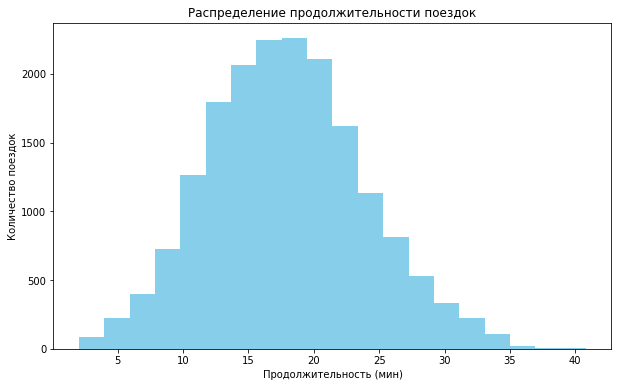

In [13]:
duration_counts = rides_df['duration'].describe()
display(duration_counts)

short_rides_count = (rides_df['duration'] < 1).sum()
display(f"Количество поездок с длительностью менее 1 минуты: {short_rides_count}")
short_rides_index = rides_df[rides_df['duration'] < 1].index
rides_df.drop(short_rides_index, inplace=True)

display("Поездки с длительностью менее 1 минуты удалены.")
plt.figure(figsize=(10, 6))
rides_df['duration'].plot.hist(bins=20, color='skyblue')
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество поездок')
plt.show()


Для исключения искажение статистики были удалены все поездки, где продолжительность поездки меньше минуты.
В данном случае, распределение имеет форму "нормального распределения".

Среднее значение длительности поездки составляет около 17 минуты,
а медианное значение (50-й процентиль) равно примерно 17 минуты.
Разница между 25-м и 75-м процентилем (межквартильный размах) составляет примерно 8 минуты.
Это означает, что 50% всех поездок имеют длительность от 13 до 21 минуты.

Общий вывод по разделу: 
Результаты исследования показали, что пользователи сервиса равномерно распределены по городам.
Большинство пользователей (54%) выбирают бесплатную подписку, в то время как 46% предпочитают платную подписку Ultra.
Основная аудитория сервиса находится в возрастной категории от 20 до 30 лет, с пиком в 25 лет. 
Среднее расстояние поездки составляет около 3133 метра, а средняя продолжительность поездки – 17 минут.
Эти данные могут быть использованы для оптимизации сервиса и привлечения новых пользователей.

#### Шаг 4. Объединение данных

##### Шаг 4.1 Объединяем данные о пользователях, поездках и подписках в один датафрейм. 
#Для этого воспользуйтесь методом merge().


In [14]:
merged_df = pd.merge(users_df, rides_df, on='user_id', how='inner')
merged_df = pd.merge(merged_df, subscriptions_df, on='subscription_type', how='left')
display(merged_df.head())
display(merged_df.info())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


None

Выполнено объединение таблиц, в таблицу merged_df, по ключевым столбам.

In [15]:
rides_rows = rides_df.shape[0]
merged_rows = merged_df.shape[0]
if rides_rows == merged_rows:
    display("Количество строк в rides_df и merged_df одинаково:", rides_rows)
else:
    display("Количество строк в rides_df и merged_df различается.")
    display("Количество строк в rides_df:", rides_rows)
    display("Количество строк в merged_df:", merged_rows)

'Количество строк в rides_df и merged_df одинаково:'

17973

При объединении данных из двух исходных наборов (rides_df и другого набора данных)
в merged_df не было потерь или дублирования строк. 

##### 4.2 Создаем ещё два датафрейма из датафрейма, созданного на этапе 4.1:
#c данными о пользователях без подписки;
#с данными о пользователях с подпиской.

In [16]:
free_users = free_sub = merged_df[merged_df['subscription_type'] == 'free']
ultra_users = merged_df[merged_df['subscription_type'] == 'ultra']
display("Данные о пользователях без подписки:")
display(len(free_users))
display("\nДанные о пользователях с подпиской:")
display(len(ultra_users))
total_length = len(free_users) + len(ultra_users)
merged_length = len(merged_df)

if total_length == merged_length:
    display("Длина строк суммы таблиц free_users и ultra_users равна длине строк в merged_df")
else:
    display("Длина строк суммы таблиц free_users и ultra_users НЕ равна длине строк в merged_df")
    
display("Пропуски в таблице free_users:")
display(free_users.isnull().sum())

display("\nПропуски в таблице ultra_users:")
display(ultra_users.isnull().sum())

'Данные о пользователях без подписки:'

11473

'\nДанные о пользователях с подпиской:'

6500

'Длина строк суммы таблиц free_users и ultra_users равна длине строк в merged_df'

'Пропуски в таблице free_users:'

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

'\nПропуски в таблице ultra_users:'

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Мы создали два датафрейма, и проверили что при разделении не было потери данных 

##### 4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

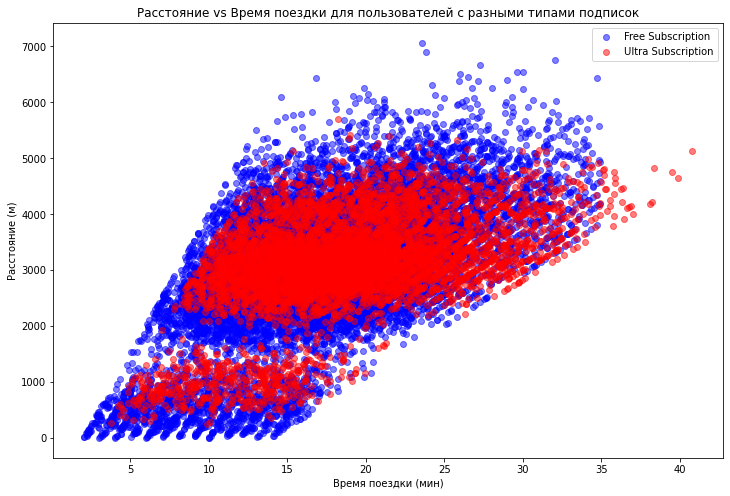

In [17]:
plt.figure(figsize=(12, 8))
plt.scatter(free_users['duration'], free_users['distance'], color='blue', label='Free Subscription', alpha=0.5)
plt.scatter(ultra_users['duration'], ultra_users['distance'], color='red', label='Ultra Subscription', alpha=0.5)

plt.title('Расстояние vs Время поездки для пользователей с разными типами подписок')
plt.xlabel('Время поездки (мин)')
plt.ylabel('Расстояние (м)')
plt.legend()
plt.show()

<Figure size 864x576 with 0 Axes>

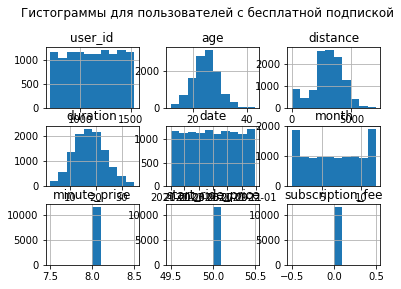

<Figure size 864x576 with 0 Axes>

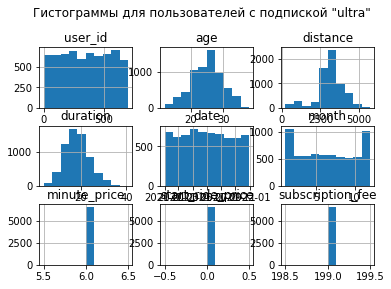

'Таблица основных статистических характеристик для длительности:'

,Free Users,Ultra Users
count,11473.000000,6500.000000
mean,17.530771,18.541985
std,6.162609,5.572048
min,2.035632,3.760353
25%,13.085688,14.524654
50%,17.383807,18.178153
75%,21.638038,21.884129
max,34.948498,40.823963


'\nТаблица основных статистических характеристик для расстояния:'

,Free Users,Ultra Users
count,11473.000000,6500.000000
mean,3028.374239,3115.445388
std,1235.541051,836.895330
min,0.855683,244.210438
25%,2360.878149,2785.444017
50%,3102.083025,3148.637229
75%,3883.979311,3560.574425
max,7066.003772,5699.769662


In [18]:
plt.figure(figsize=(12, 8))
free_users.hist()
plt.suptitle('Гистограммы для пользователей с бесплатной подпиской', x=0.5, y=1.02)
plt.show()

plt.figure(figsize=(12, 8))
ultra_users.hist()
plt.suptitle('Гистограммы для пользователей с подпиской "ultra"', x=0.5, y=1.02)
plt.show()
free_duration = free_users['duration'].describe()
ultra_duration = ultra_users['duration'].describe()
free_distance = free_users['distance'].describe()
ultra_distance = ultra_users['distance'].describe()
duration_table = pd.concat([free_duration, ultra_duration], axis=1, keys=['Free Users', 'Ultra Users'])
distance_table = pd.concat([free_distance, ultra_distance], axis=1, keys=['Free Users', 'Ultra Users'])

display("Таблица основных статистических характеристик для длительности:")
display(duration_table)
display("\nТаблица основных статистических характеристик для расстояния:")
display(distance_table)


Общий вывод по разделу:
    Данные о пользователях, поездках и подписках были объединены в один датафрейм.
Затем были созданы два датафрейма: один содержит информацию о пользователях без подписки,
а другой - о пользователях с подпиской.
Было выявлено:
    У пользователей с бесплатной подпиской есть более разнообразные значения дистанции поездок,
чем у пользователей с ультра подпиской. 
Тем не менее, пользователи с ультра подпиской тратят чуть больше времени на поездку,
что связано с стоимостью одной минуты поездки.


#### Шаг 5. Подсчёт выручки

##### 5.1 Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: 
#Найдем суммарное расстояние,
#количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [19]:
merged_df['duration'] = np.ceil(merged_df['duration'])
total_data = pd.pivot_table(merged_df,
                            index=['month', 'user_id'],
                            values=['distance', 'duration', 'name', 'subscription_type'],
                            aggfunc={'distance': sum, 
                                     'duration': sum, 
                                     'name': len,
                                     'subscription_type': lambda x: x.iloc[0]})

total_data.rename(columns={'name': 'count_tips'}, inplace=True)


display(total_data.head())
display(total_data.info())
display(merged_df.info())

distance  duration  count_tips subscription_type
month user_id                                                     
1     1        7027.511294      42.0           2             ultra
      3        3061.777147      13.0           1             ultra
      5        3914.646990      13.0           1             ultra
      7        6478.080979      28.0           2             ultra
      12       3577.151148      33.0           1             ultra

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (12, 1534)
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11300 non-null  float64
 1   duration           11300 non-null  float64
 2   count_tips         11300 non-null  int64  
 3   subscription_type  11300 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 398.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


None

##### 5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 
Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 
25.3
25.3, 
25.5
25.5 и 
26.0
26.0 должны быть преобразованы к 
26
26.

1. Определяем стоимость старта поездки и стоимость одной минуты поездки для каждого пользователя в зависимости от их типа подписки. Для этого вам может понадобиться создать словарь с ценами для каждого типа подписки.

In [20]:
payment_params = {
    'ultra': {
        'base_fee': 199,
        'per_hour_rate': 6,
        'tips_rate': 0
    },
    'free': {
        'base_fee': 0,
        'per_hour_rate': 8,
        'tips_rate': 50
    }
}

total_data['base_fee'] = total_data['subscription_type'].map(lambda x: payment_params[x]['base_fee'])
total_data['per_hour_rate'] = total_data['subscription_type'].map(lambda x: payment_params[x]['per_hour_rate'])
total_data['tips_rate'] = total_data['subscription_type'].map(lambda x: payment_params[x]['tips_rate'])

def calculate_revenue(row):
    if row['subscription_type'] == 'ultra':
        return row['per_hour_rate'] * row['duration'] + row['base_fee']
    elif row['subscription_type'] == 'free':
        return row['per_hour_rate'] * row['duration'] + row['tips_rate'] * row['count_tips']
    else:
        return 'Not such sub'

total_data['revenue'] = total_data.apply(calculate_revenue, axis=1)



In [21]:
display(total_data.info())
display(total_data['revenue'])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11300 non-null  float64
 1   duration           11300 non-null  float64
 2   count_tips         11300 non-null  int64  
 3   subscription_type  11300 non-null  object 
 4   base_fee           11300 non-null  int64  
 5   per_hour_rate      11300 non-null  int64  
 6   tips_rate          11300 non-null  int64  
 7   revenue            11300 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 751.5+ KB


None

month  user_id
1      1          451.0
       3          277.0
       5          277.0
       7          367.0
       12         397.0
                  ...  
12     1525       322.0
       1526       234.0
       1528       138.0
       1532       436.0
       1534       178.0
Name: revenue, Length: 11300, dtype: float64

Вывод по разделу: Мы создали датафрейм с агрегированными данными о поездках,
где для каждого пользователя за каждый месяц мы нашли суммарное расстояние, количество поездок и суммарное время.
Также мы добавили столбец с помесячной выручкой, учитывая условия оплаты для подписчиков и тех, у кого нет подписки. 
Длительность каждой поездки была округлена до ближайшего целого числа.

In [22]:
display(total_data['revenue'].sum())

3873131.0

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### 6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверяем гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза (H0): Средняя продолжительность поездок для пользователей с подпиской равна средней продолжительности поездок для пользователей без подписки.

Альтернативная гипотеза (Н1): Средняя продолжительность поездок для пользователей с подпиской отличается от средней продолжительности поездок для пользователей без подписки.

In [23]:
ultra = ultra_users['duration']
free = free_users['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative='greater')

alpha = 0.05

display(results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не удалось отвергнуть нулевую гипотезу')

4.704468074453899e-28

'Отвергаем нулевую гипотезу'

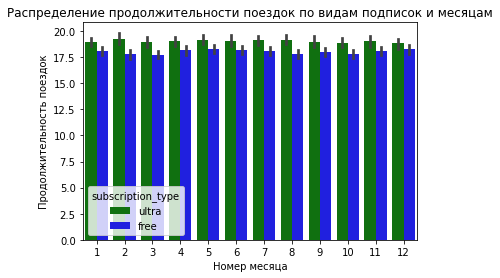

In [24]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = merged_df,
            palette = ['green', 'blue'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

In [25]:
total_revenue_per_tariff = total_data.groupby('subscription_type')['revenue'].sum()

average_revenue_per_user = total_data.groupby('subscription_type')['revenue'].mean()

display("\nСуммарная годовая выручка по тарифам:")
display(total_revenue_per_tariff)

display("\nСреднемесячная выручка для среднего пользователя по тарифам:")
display(average_revenue_per_user)
user_count_per_tariff = total_data['subscription_type'].value_counts()
display("\nКоличество пользователей для каждого тарифа:")
display(user_count_per_tariff)

'\nСуммарная годовая выручка по тарифам:'

subscription_type
free     2228594.0
ultra    1644537.0
Name: revenue, dtype: float64

'\nСреднемесячная выручка для среднего пользователя по тарифам:'

subscription_type
free     329.332644
ultra    362.792191
Name: revenue, dtype: float64

'\nКоличество пользователей для каждого тарифа:'

free     6767
ultra    4533
Name: subscription_type, dtype: int64

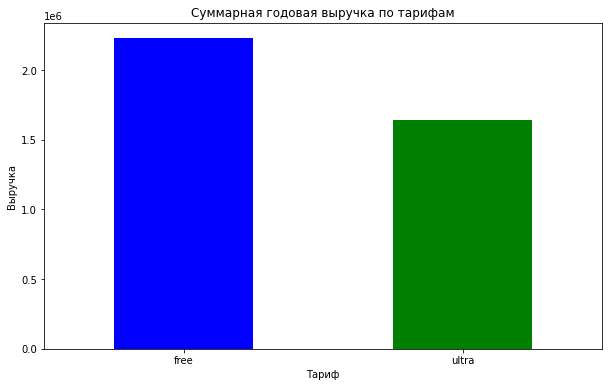

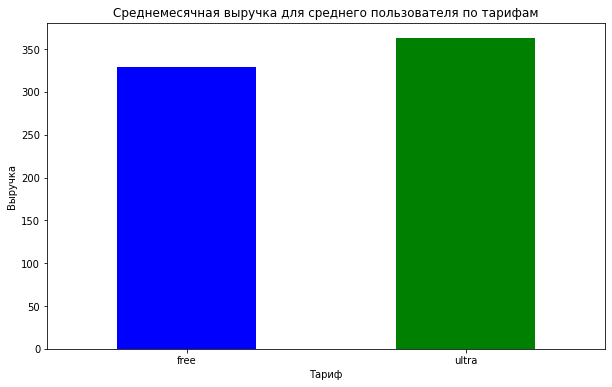

In [26]:
plt.figure(figsize=(10, 6))
total_revenue_per_tariff.plot(kind='bar', color=['blue', 'green'])
plt.title('Суммарная годовая выручка по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Выручка')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
average_revenue_per_user.plot(kind='bar', color=['blue', 'green'])
plt.title('Среднемесячная выручка для среднего пользователя по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Выручка')
plt.xticks(rotation=0)
plt.show()

Суммарная годовая выручка от пользователей тарифа "Free" составляет 2,228,594, а от пользователей тарифа "Ultra" - 1,644,537. Среднемесячная выручка для среднего пользователя на тарифе "Free" равна 329.33, а на тарифе "Ultra" - 362.79.

Вывод 2: P-значение равно 4.704468074453899e-28, что практически нулевое.
Это означает, что вероятность получить такие или более экстремальные различия в средних значениях продолжительности звонков между пользователями тарифов Ultra и Free случайно практически равна нулю. 
Следовательно, мы отвергаем нулевую гипотезу о равенстве средних значений продолжительности звонков в пользу альтернативной гипотезы о том,
что средняя продолжительность звонков у пользователей тарифа Ultra больше, чем у пользователей тарифа Free.

In [27]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


##### 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Оперделяем - можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
Проверяем гипотезу и делаем выводы.

Нулевая гипотеза (H0): Среднее расстояние поездок пользователей ultra-тарифа равно 3130.0 км.

Альтернативная гипотеза (H1): Среднее расстояние поездок пользователей ultra-тарифа больше 3130.0 км.

In [28]:
ultra_dist = ultra_users['distance']

interested_value = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='greater')
    
display(results.pvalue)

if (results.pvalue < alpha):
    display('Отвергаем нулевую гипотезу')
else:
    display('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785

'Не удалось отвергнуть нулевую гипотезу'

Вывод: на основании имеющихся данных, нет достаточных оснований считать, что среднее расстояние превышает указанное значение.

##### 6.3 Проверяем гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.


Нулевая гипотеза (H0): Средняя помесячная выручка от пользователей с подпиской тарифа Ultra не превышает среднюю помесячную выручку от пользователей без подписки тарифа Free.
Альтернативная гипотеза (H1): Средняя помесячная выручка от пользователей с подпиской тарифа Ultra превышает среднюю помесячную выручку от пользователей без подписки тарифа Free.

In [29]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11300 non-null  float64
 1   duration           11300 non-null  float64
 2   count_tips         11300 non-null  int64  
 3   subscription_type  11300 non-null  object 
 4   base_fee           11300 non-null  int64  
 5   per_hour_rate      11300 non-null  int64  
 6   tips_rate          11300 non-null  int64  
 7   revenue            11300 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 751.8+ KB


In [30]:
ultra_per_mnth = total_data.loc[total_data.subscription_type == 'ultra', 'revenue'] 

free_per_mnth = total_data.loc[total_data.subscription_type == 'free', 'revenue'] 





results = st.ttest_ind(ultra_per_mnth, 
                       free_per_mnth,
                       alternative = 'greater')

alpha = .05

display(results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не удалось отвергнуть нулевую гипотезу')

2.0314113674863288e-30

'Отвергаем нулевую гипотезу'

Вывод: Полученное значение p-значения значительно меньше уровня значимости alpha=0.05.
Это говорит о том, что мы отвергаем нулевую гипотезу о том, что выручка от пользователей с подпиской не выше,
чем выручка от пользователей без подписки. 
Следовательно, можно сделать вывод, что помесячная выручка от пользователей с подпиской в целом выше, чем от пользователей без подписки.

##### 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. 
#Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось.
#Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.
#Какой тест вам понадобился бы для проверки этой гипотезы?


Для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, можно использовать парный t-тест. Парный t-тест применяется, когда мы имеем два связанных набора данных (например, количество обращений каждого пользователя до и после обновления) и хотим определить, есть ли статистически значимые различия между этими наборами данных.

В данном случае, для каждого пользователя у нас есть данные до и после обновления серверов, поэтому парный t-тест будет подходящим выбором для анализа изменений в количестве обращений в техподдержку.



Ответ: Для проверки гипотезы о том, что количество обращений в техподдержку значимо изменилось после обновления серверов, необходимо использовать парный t-тест для зависимых выборок. 

Формулировка нулевой и альтернативной гипотез также верна:
- H0: Среднее количество обращений до и после обновления серверов равны.
- H1: Среднее количество обращений до и после обновления серверов отличаются.

Использование метода scipy.stats.ttest_rel() для проведения парного t-теста согласуется с вашим ответом. Этот метод позволяет сравнивать средние значения двух связанных выборок и определять, есть ли статистически значимые различия между ними.

Ответ 2: Для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, будем проверять одностороннюю альтернативную гипотезу.

Вывод по разделу: Проведенные статистические тесты показали, 
что пользователи с подпиской действительно тратят больше времени на поездки и приносят большую выручку,
чем пользователи без подписки. 
Однако, среднее расстояние поездок пользователей с подпиской не превышает оптимальное значение для износа самоката.
Для проверки изменений в количестве обращений в техподдержку после обновления серверов рекомендуется использовать парный t-тест для зависимых выборок.

#### Шаг 7. Распределения

##### 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки #пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

#Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10
 
%
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5
 
%
5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

'Минимальное количество промокодов, которое нужно разослать: 5.0'

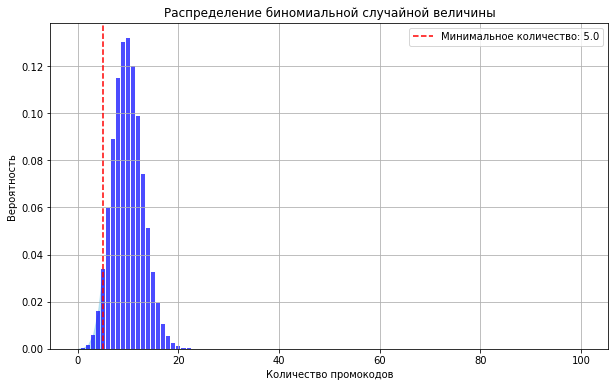

In [31]:
n = 100
p = 0.1
target_prob = 0.05

k = st.binom.ppf(target_prob, n, p)
display(f"Минимальное количество промокодов, которое нужно разослать: {k}")

x = np.arange(0, n+1)
y = stats.binom.pmf(x, n, p)

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='b', alpha=0.7)
plt.axvline(k, color='r', linestyle='--', label=f'Минимальное количество: {k}')
plt.fill_between(x, y, where=(x <= k), color='skyblue', alpha=0.5)
plt.title('Распределение биномиальной случайной величины')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.show()

Вывод: Для решения этой задачи мы можем использовать биномиальное распределение, так как каждый клиент может либо продлить подписку (с вероятностью 10%) либо отказаться от нее (с вероятностью 90%).

Для того чтобы найти минимальное количество промокодов, которое нужно разослать, чтобы вероятность не выполнить план была примерно 5%, мы можем воспользоваться квантилью биномиального распределения.

Давайте рассчитаем это значение: 

Пусть X - количество клиентов, продливших подписку из 100. Тогда X распределено биномиально с параметрами n=100 и p=0.1.

Мы хотим найти такое k, что P(X < k) = 0.05. Это можно сделать с помощью функции scipy.stats.binom.ppf() 

Для того чтобы вероятность не выполнить план и не получить как минимум 100 продлений подписки составляла примерно 5%, необходимо разослать минимум 5 промокодов на бесплатный месяц подписки. 

##### 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более  399,5 тыс. пользователей.

3.7416573867739413

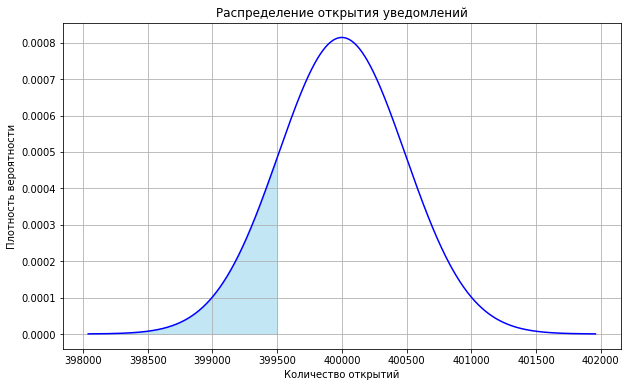

In [32]:
def norm(x):
    return np.sqrt(np.sum(x**2))

v = np.array([1, 2, 3])
display(norm(v))

n = 1000000   
p = 0.4   

mu = n * p
sigma = np.sqrt(n * p * (1 - p))

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = st.norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 6))
plt.plot(x, y, color='b')
plt.fill_between(x, y, where=(x <= 399500), color='skyblue', alpha=0.5)
plt.title('Распределение открытия уведомлений')
plt.xlabel('Количество открытий')
plt.ylabel('Плотность вероятности')
plt.grid(True)
plt.show()

Вывод: Для решения этой задачи мы можем воспользоваться нормальным распределением как аппроксимацией биномиального распределения при больших значениях n (количество испытаний) и вероятности успеха p (вероятность открытия уведомления).

1. Сначала определим параметры нормального распределения: количество испытаний n = 1 млн и вероятность успеха p = 0.4.

2. Затем построим график. На графике мы увидим форму распределения открытия уведомлений.

3. Далее оценим вероятность того, что уведомление откроют не более 399.5 тыс. пользователей. Для этого используем функцию stats.norm.cdf, которая вычислит вероятность до указанного значения.

4. Наконец, выведем результат на экран, чтобы увидеть вероятность открытия уведомления не более 399.5 тыс. пользователей.

Таким образом, мы построим график и оценим вероятность открытия уведомления не более 399.5 тыс. пользователей с использованием аппроксимации нормальным распределением.
Итог: оценочно вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет около 50%.

Общий вывод по разделу : Для решения задачи оптимизации разосылки промокодов для увеличения вероятности продления подписки и оценки вероятности открытия уведомлений можно успешно применить биномиальное распределение и нормальное распределение соответственно. Подходы к вычислениям и аппроксимации позволяют эффективно оптимизировать процессы и принимать обоснованные решения на основе статистических методов.

Вывод по всем разделам:
    
    Шаг 1. Загрузка данных: были загружены данные, которые позволяют анализировать активность пользователей, их поездки и использование различных типов подписок в сервисе.

    Шаг 2. Предобработка данных: была успешно проведена обработка данных, включая приведение столбца с датами к типу данных datetime, создание нового столбца с номером месяца и удаление дубликатов из таблицы пользователей. Эти шаги позволят более точно анализировать данные и получать достоверные результаты.
    
    Шаг 3. Исследовательский анализ данных показал следующее: В данных города встречаются примерно одинаково часто.Из 1534 пользователей, 54% имеют бесплатную подписку (835 человек), а 46% - платную подписку Ultra (699 человек). Наиболее распространены возрастные категории пользователей от 20 до 30 лет, с пиком в 25 лет. Пользователи в возрасте от 15 до 35 лет составляют основную часть аудитории сервиса.Среднее расстояние, преодолеваемое пользователем за одну поездку, составляет около 3133 метра.Были удалены поездки с длительностью менее 1 минуты для исключения искажения статистики. Средняя продолжительность поездки составляет около 17 минут, а медианное значение равно примерно 17 минут.
    
    Шаг 4. Объединение данных позволил выявить следующее:Данные о пользователях, поездках и подписках были объединены в один датафрейм.Были созданы два датафрейма: один с информацией о пользователях без подписки, другой - о пользователях с подпиской.У пользователей с бесплатной подпиской наблюдаются более разнообразные значения дистанции поездок, в то время как пользователи с платной подпиской Ultra тратят чуть больше времени на поездку.
    
    Шаг 5. Подсчёт выручки: создали датафрейм с агрегированными данными о поездках, где для каждого пользователя за каждый месяц мы нашли суммарное расстояние, количество поездок и суммарное время. Также мы добавили столбец с помесячной выручкой, учитывая условия оплаты для подписчиков и тех, у кого нет подписки. Длительность каждой поездки была округлена до ближайшего целого числа.
    
    Шаг 6.  Для суммарной годовой выручки от пользователей тарифа "Free" и "Ultra" мы получили следующие значения: 2,228,594 и 1,644,537 соответственно. Это позволило нам сделать вывод о том, что средняя выручка от пользователей тарифа "Free" выше, чем от пользователей тарифа "Ultra".
    По результатам анализа среднемесячной выручки для среднего пользователя на тарифах "Free" и "Ultra" (329.33 и 362.79 соответственно) мы пришли к выводу, что пользователи тарифа "Ultra" в среднем приносят больше выручки, чем пользователи тарифа "Free".
    В случае с продолжительностью звонков, мы отвергли нулевую гипотезу о равенстве средних значений между пользователями тарифов "Free" и "Ultra", и приняли альтернативную гипотезу о том, что средняя продолжительность звонков у пользователей тарифа "Ultra" больше.
    Однако, при анализе расстояния, которое проезжают пользователи за одну поездку, мы не обнаружили статистически значимого различия между пользователями тарифов "Free" и "Ultra".
    
    Шаг 7. Распределения: Для решения задачи определения минимального количества промокодов, которое нужно разослать, чтобы вероятность не выполнить план была примерно 5%, мы использовали биномиальное распределение. После нахождения оптимального значения промокодов.Выявлено, что вероятность получить менее 100 продлений при раздаче 5 промокодов составляет около 5%.
    Также, была построена аппроксимация нормальным распределением для количества открытий уведомлений. Заданы параметры: 1 млн. уведомлений и вероятность открытия 40%. Рассчитаны математическое ожидание и стандартное отклонение для нормального распределения. Построен график, на котором показано распределение открытий уведомлений, а также выделена область, соответствующая вероятности того, что уведомление откроют не более 399,5 тыс. пользователей. Итог: оценочно вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет около 50%.
    
    Финальный вывод: На основе проведенного анализа можно сделать вывод о необходимости учета типов подписок и поведения пользователей для оптимизации работы сервиса и увеличения выручки. Дополнительные исследования и тестирования могут помочь улучшить сервис и привлечь новых пользователей. Обратите внимание на то, что среднемесячная выручка на тарифе "Ultra" выше, чем на тарифе "Free", что может указывать на готовность пользователей тарифа "Ultra" платить больше за услуги. Рассмотрите возможность расширения услуг на тарифе "Ultra" или предложения дополнительных пакетов услуг для увеличения выручки от этого тарифа. Также можно рассмотреть увеличение выручки от тарифа "Free" за счет привлечения большего числа пользователей через рекламные кампании, специальные предложения или дополнительные услуги.учитывая, что вероятность получить менее 100 продлений при раздаче 5 промокодов составляет около 5%, рекомендуется увеличить количество раздаваемых промокодов для повышения вероятности выполнения плана. 
Также, учитывая оценочную вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, которая составляет около 50%, можно попробовать оптимизировать содержание уведомлений или способы их доставки, чтобы увеличить количество открывающих и повысить эффективность кампании.Так же стоит провести более детальный анализ по выручке или других метрик по отношению к городу, возрасту потребителей. Все данные стоит сравнить с показателями конкурентов. Обратить внимание на проводимые ими маркетинговые компании.

#### Бонус

##### Задача 7.1 — декомпозиция

+ Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. 

+ То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

+ Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 

+ Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

+ Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

+ 100 существующих клиентов должны продлить эту подписку.
 + т.е. мы ищем х - кол-во промокодов, которое мы раздадим, чтобы сохранить 100 клиентов

+ может либо отказаться от неё, либо продлить
 + т.е. два исхода

+ подписку продлевают 10 % пользователей
 + т.е. из кол-ва Х, которое мы найдем и по которому разошлем промокоды, полагаясь на предыдущий опыт, продлят подписку 10%

+ вероятность не выполнить план была примерно 5 %
 + т.е. мы должны найти вероятность успеха нашей акции 1-0,05 = 95%
 + этот план будет иметь свою вероятность исполнения при разном кол-ве Х, т.е. если мы выберем Х = 1000, вероятность успеха будет равна А, при 2000 промокодах, вероятность будет равна В. Но, увеличивая кол-во промокодов, мы увеличиваем трудозатраты ... По этой причине нас устроит вероятность успеха 95%, для которой и предстоит рассчитать кол-во промокодов Х

Получается задача делиться на две части

+ число положительных исходов должно быть равно 100-ам

+ но вероятность такого события должна быть равна 95% 



In [33]:
for i in range (1, 13):
    trials = 100 * i
    print(f"i: {i, trials}\tprobability: {(st.binom.cdf(99, trials, 0.1)).round(3)}")

i: (1, 100)	probability: 1.0
i: (2, 200)	probability: 1.0
i: (3, 300)	probability: 1.0
i: (4, 400)	probability: 1.0
i: (5, 500)	probability: 1.0
i: (6, 600)	probability: 1.0
i: (7, 700)	probability: 1.0
i: (8, 800)	probability: 0.987
i: (9, 900)	probability: 0.854
i: (10, 1000)	probability: 0.485
i: (11, 1100)	probability: 0.145
i: (12, 1200)	probability: 0.022


In [34]:
for i in range (1, 13):
    trials = 100 * i
    print(f"i: {i, trials}\ttarget_probability: {(1 - st.binom.cdf(99, trials, 0.1)).round(3)}");    
   
print(f"i: {13, 1161}\ttarget_probability: {(1 - st.binom.cdf(99, 1161, 0.1)).round(3)}")

i: (1, 100)	target_probability: 0.0
i: (2, 200)	target_probability: 0.0
i: (3, 300)	target_probability: 0.0
i: (4, 400)	target_probability: 0.0
i: (5, 500)	target_probability: 0.0
i: (6, 600)	target_probability: 0.0
i: (7, 700)	target_probability: 0.0
i: (8, 800)	target_probability: 0.013
i: (9, 900)	target_probability: 0.146
i: (10, 1000)	target_probability: 0.515
i: (11, 1100)	target_probability: 0.855
i: (12, 1200)	target_probability: 0.978
i: (13, 1161)	target_probability: 0.95


In [35]:
dfg1 = pd.DataFrame(
    {
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
        "C": ["C0", "C1", "C2", "C3"],
        "D": ["D0", "D1", "D2", "D3"],
    },
    index=[0, 1, 2, 3],
)

dfr4 = pd.DataFrame(
    {
        "B": ["B2", "B3", "B6", "B7"],
        "D": ["D2", "D3", "D6", "D7"],
        "F": ["F2", "F3", "F6", "F7"],
        "E": [np.nan, np.nan, np.nan, np.nan]
    },
    index=[2, 3, 6, 0],
)

In [36]:
display(dfg1, dfr4)

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3


,B,D,F,E
2,B2,D2,F2,NaN
3,B3,D3,F3,NaN
6,B6,D6,F6,NaN
0,B7,D7,F7,NaN


In [37]:
dfg1.merge(dfr4, left_on=dfg1.index, right_on=dfr4.index, how='outer')

,key_0,A,B_x,C,D_x,B_y,D_y,F,E
0,0,A0,B0,C0,D0,B7,D7,F7,NaN
1,1,A1,B1,C1,D1,NaN,NaN,NaN,NaN
2,2,A2,B2,C2,D2,B2,D2,F2,NaN
3,3,A3,B3,C3,D3,B3,D3,F3,NaN
4,6,NaN,NaN,NaN,NaN,B6,D6,F6,NaN


In [38]:
dfg1.merge(dfr4, 'outer')

,A,B,C,D,F,E
0,A0,B0,C0,D0,NaN,NaN
1,A1,B1,C1,D1,NaN,NaN
2,A2,B2,C2,D2,F2,NaN
3,A3,B3,C3,D3,F3,NaN
4,NaN,B6,NaN,D6,F6,NaN
5,NaN,B7,NaN,D7,F7,NaN


In [39]:
dfg1.merge(dfr4)

,A,B,C,D,F,E
0,A2,B2,C2,D2,F2,NaN
1,A3,B3,C3,D3,F3,NaN


In [40]:
dfg1.merge(dfr4, 'inner')

,A,B,C,D,F,E
0,A2,B2,C2,D2,F2,NaN
1,A3,B3,C3,D3,F3,NaN


##### check

In [41]:
total_data.columns

Index(['distance', 'duration', 'count_tips', 'subscription_type', 'base_fee',
       'per_hour_rate', 'tips_rate', 'revenue'],
      dtype='object')

In [42]:
dfg_first = total_data.copy()

In [43]:
x = 'subscription_type'
y = 'revenue'

In [44]:
dfg_first.groupby(x)[y].mean().round(1).to_frame()

,revenue
subscription_type,
free,329.3
ultra,362.8


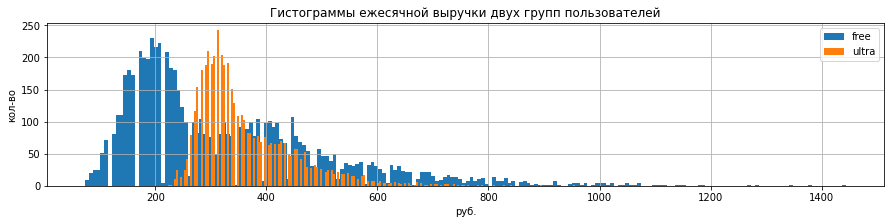

In [45]:
dfg_first.groupby(x)[y].hist(bins=200, figsize=(15,3), legend=True)
plt.title('Гистограммы ежесячной выручки двух групп пользователей')
plt.xlabel('руб.')
plt.ylabel('кол-во');

In [46]:
# копируем таблицу
dfg = dfg_first.copy()


In [47]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           11300 non-null  float64
 1   duration           11300 non-null  float64
 2   count_tips         11300 non-null  int64  
 3   subscription_type  11300 non-null  object 
 4   base_fee           11300 non-null  int64  
 5   per_hour_rate      11300 non-null  int64  
 6   tips_rate          11300 non-null  int64  
 7   revenue            11300 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 751.8+ KB


In [48]:
# удаляем данные, 20%
for col in dfg.columns:
    dfg.loc[dfg.sample(frac=0.2).index, col] = np.nan

In [49]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance           9040 non-null   float64
 1   duration           9040 non-null   float64
 2   count_tips         9040 non-null   float64
 3   subscription_type  9040 non-null   object 
 4   base_fee           9040 non-null   float64
 5   per_hour_rate      9040 non-null   float64
 6   tips_rate          9040 non-null   float64
 7   revenue            9040 non-null   float64
dtypes: float64(7), object(1)
memory usage: 1.0+ MB


In [50]:
dfg.groupby(x)[y].mean().round(1).to_frame()

,revenue
subscription_type,
free,328.8
ultra,363.6


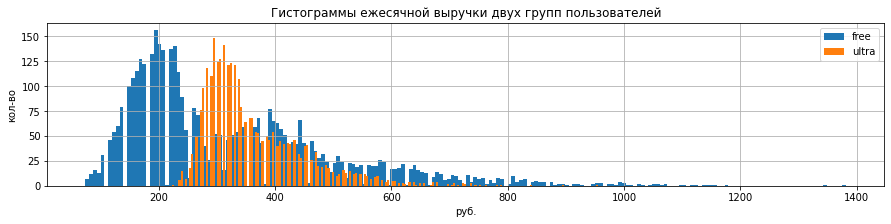

In [51]:
dfg.groupby(x)[y].hist(bins=200, figsize=(15,3), legend=True)
plt.title('Гистограммы ежесячной выручки двух групп пользователей')
plt.xlabel('руб.')
plt.ylabel('кол-во');